In [16]:
import yfinance as yf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

today = pd.to_datetime('today').date()

# Data Collection

In [17]:
def getData(ticker, start_date = '2020-01-01', end_date = today, interval = '1d'):
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    return data

In [18]:
tickers = ['AAPL', 'MSFT', 'GOOGL',]

# generate df
df = pd.DataFrame()
for ticker in tickers:
    data = getData(ticker)
    data = data['Adj Close']
    data = data.rename(ticker)
    df = df.merge(data, how='outer', left_index=True, right_index=True)


df.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AAPL,MSFT,GOOGL
Date,,,
2024-06-27,214.100006,452.850006,185.410004
2024-06-28,210.619995,446.950012,182.149994
2024-07-01,216.750000,456.730011,182.990005
2024-07-02,220.270004,459.279999,185.240005
2024-07-03,221.550003,460.769989,185.820007


<Axes: xlabel='Date'>

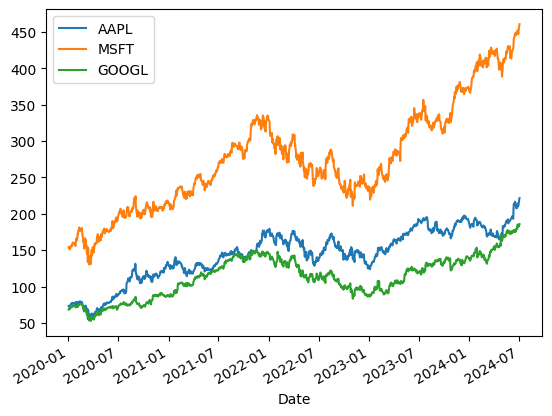

In [10]:
df.plot()

# LSTM

A recurent neural network (RNN).
1. First normalise the data using a min-max scaler to make gradient descent more efficient
2. Split into sequences of size $k$ and use it to train the neural network
  - let $S = [a_1, ... , a_k]$ where S represents a single training segment
  - the subsequence $[a_1, .. , a_{k-1}]$ is the input to and $a_k$ is the output
  - We use a sequence size of 10 and every $a_i$ where $i>10$ is taken as 1 output. This gives $n-9$ sequences where $n$ is the size of the training set
3. Then you just plug into the model


In [5]:
def run_LSTM(df, stock, lstm_units = 150, num_layers = 1, dropout = 0.0, epochs = 100, batch_size = 32, learning_rate=0.001):
  series = df[stock]
  data = np.array(series).reshape(-1,1)
  # step 1 - normalise
  from sklearn.preprocessing import MinMaxScaler
  scalar = MinMaxScaler()
  scaled_data = scalar.fit_transform(data)

  # step 2 - split into traing and testing
  p = 0.8
  train_size = int(len(scaled_data) * p)
  test_size = len(scaled_data) - train_size
  train, test = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]

  # step 3 - create sequences
  def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data)-seq_len):
      X.append(data[i:i+seq_len])
      y.append(data[i+seq_len])
    return np.array(X), np.array(y)

  seq_len = 60
  X_train, y_train = create_sequences(train, seq_len)
  X_test, y_test = create_sequences(test, seq_len)

  # step 4 - build model
  model = Sequential()
  for i in range(num_layers):
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(seq_len, 1)))
    model.add(Dropout(dropout))
  model.add(LSTM(lstm_units))
  # model.add(Dropout(dropout))

  model.add(Dense(1))

  # step 5 - train model
  from keras.optimizers import Adam
  opt = Adam(learning_rate=learning_rate)
  model.compile(optimizer=opt, loss='mean_squared_error')
  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

  # step 6 - test model
  predictions = model.predict(X_test)
  predictions = scalar.inverse_transform(predictions)
  y_test = scalar.inverse_transform(y_test)

  from sklearn.metrics import mean_squared_error
  accuracy = mean_squared_error(y_test, predictions)

  return predictions, accuracy





In [6]:
def plot_predictions(predictions, stock):
  # create resultant df
  predictions = predictions.flatten()
  result = df[-len(predictions):]
  result['Predicted'] = predictions
  result = result[[stock, 'Predicted']]
  result.rename(columns={stock:'Actual'}, inplace=True)

  # Plot the actual and predicted prices
  plt.figure(figsize=(12, 6))
  plt.plot(result['Actual'], color='blue', label='Actual Stock Price')
  plt.plot(result['Predicted'], color='red', label='Predicted Stock Price')
  plt.title(stock +' Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Stock Price ($)')
  plt.legend()
  plt.show()

  return result


In [7]:
def drawdowns(returns):
  # takes a series of returns as the argument

  # use daily returns on the stock
  returns = returns.pct_change()
  # fill
  returns.fillna(0.0, inplace=True)

  # cumulative returns
  cumulative = (returns+1).cumprod()

  # calculate running max
  running_max = np.maximum.accumulate(cumulative)

  # calculate drawdowns
  drawdowns = (cumulative - running_max) / running_max

  return drawdowns

def max_drawdown(returns):
  return np.min(drawdowns(returns))


# AAPL

In [8]:
predictions, accuracy = run_LSTM(df, 'AAPL', lstm_units = 100, num_layers = 1, dropout = 0, epochs = 40, batch_size = 60, learning_rate=0.005)

Epoch 1/40
48/48 [==============================] - 16s 21ms/step - loss: 0.0019
Epoch 2/40
48/48 [==============================] - 1s 20ms/step - loss: 6.8033e-05
Epoch 3/40
48/48 [==============================] - 1s 22ms/step - loss: 6.9121e-05
Epoch 4/40
48/48 [==============================] - 1s 23ms/step - loss: 1.0654e-04
Epoch 5/40
48/48 [==============================] - 1s 27ms/step - loss: 7.7258e-05
Epoch 6/40
48/48 [==============================] - 1s 28ms/step - loss: 7.8780e-05
Epoch 7/40
48/48 [==============================] - 1s 22ms/step - loss: 9.2446e-05
Epoch 8/40
48/48 [==============================] - 1s 24ms/step - loss: 6.2903e-05
Epoch 9/40
48/48 [==============================] - 1s 18ms/step - loss: 5.2585e-05
Epoch 10/40
48/48 [==============================] - 1s 21ms/step - loss: 7.0839e-05
Epoch 11/40
48/48 [==============================] - 1s 24ms/step - loss: 6.3686e-05
Epoch 12/40
48/48 [==============================] - 1s 26ms/step - loss: 4.4

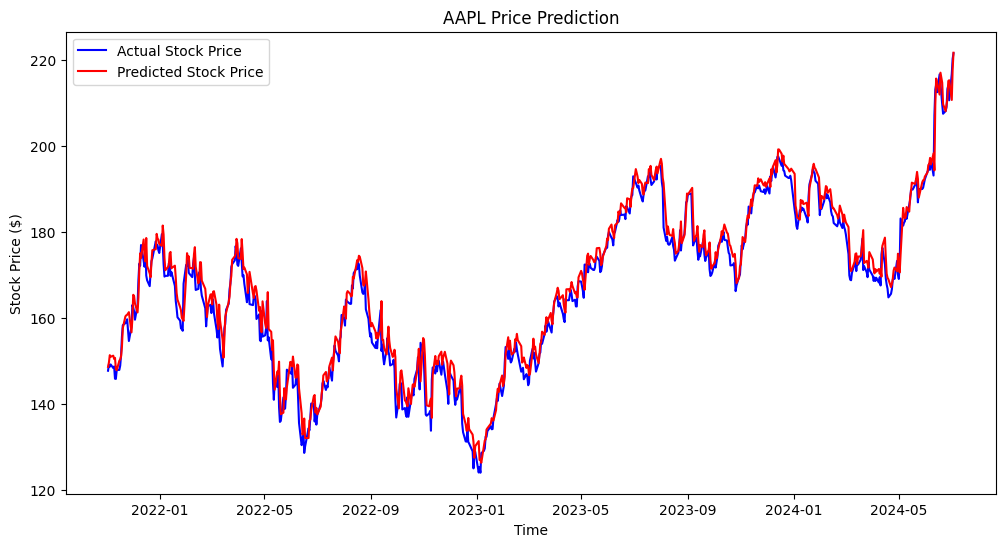

11.457450248119804

In [9]:
aapl = plot_predictions(predictions, 'AAPL')
accuracy

## Actual Drawdowns

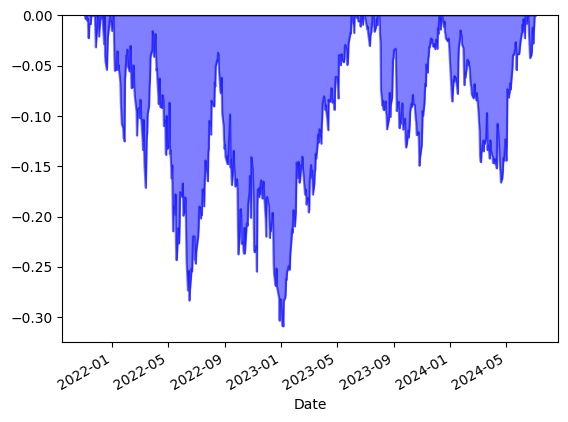

<Axes: xlabel='Date'>

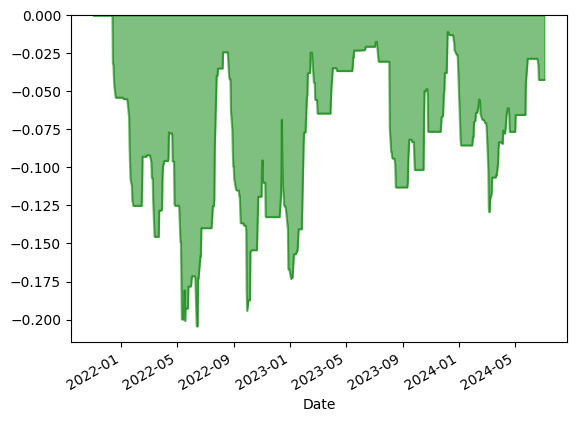

In [10]:
actual = aapl['Actual']
drawdowns(actual).plot(kind='area', color = 'blue' ,alpha=0.5)
plt.show()

actual.rolling(30).apply(max_drawdown).plot(kind='area', color = 'green' ,alpha=0.5)

## Predicted Drawdowns

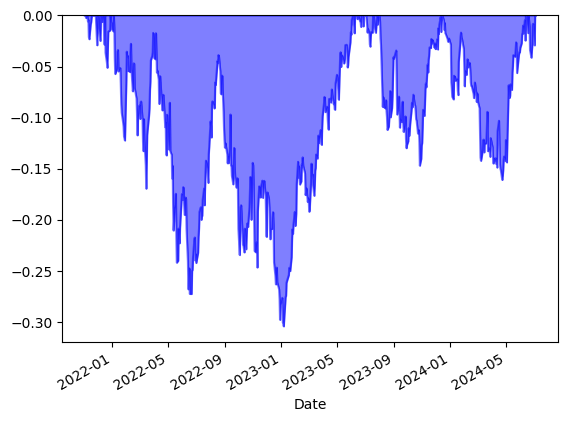

<Axes: xlabel='Date'>

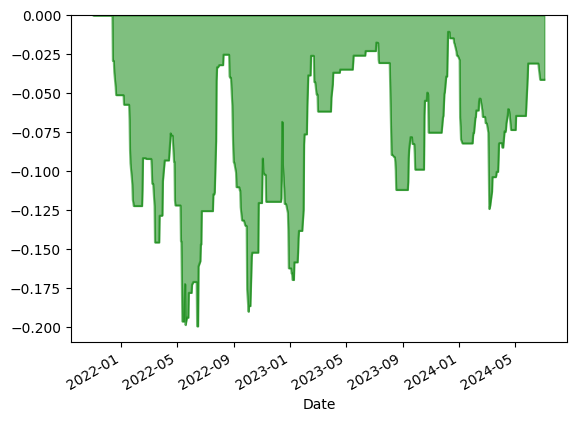

In [11]:
# drawdowns
predicted = aapl['Predicted']
drawdowns(predicted).plot(kind='area', color = 'blue' ,alpha=0.5)
plt.show()

# applied on a rolling basis of 30 days
predicted.rolling(30).apply(max_drawdown).plot(kind='area', color = 'green' ,alpha=0.5)

# Microsoft

In [ ]:
predictions, accuracy = run_LSTM(df, 'MSFT', lstm_units = 100, num_layers = 1, dropout = 0, epochs = 50, batch_size = 60, learning_rate=0.001)

Epoch 1/50
48/48 [==============================] - 16s 197ms/step - loss: 0.0023
Epoch 2/50
48/48 [==============================] - 10s 196ms/step - loss: 6.0613e-05
Epoch 3/50
48/48 [==============================] - 10s 218ms/step - loss: 5.0563e-05
Epoch 4/50
48/48 [==============================] - 9s 198ms/step - loss: 5.5137e-05
Epoch 5/50
48/48 [==============================] - 9s 180ms/step - loss: 6.3795e-05
Epoch 6/50
48/48 [==============================] - 10s 215ms/step - loss: 5.5867e-05
Epoch 7/50
48/48 [==============================] - 10s 210ms/step - loss: 5.6524e-05
Epoch 8/50
48/48 [==============================] - 8s 170ms/step - loss: 4.8447e-05
Epoch 9/50
48/48 [==============================] - 10s 217ms/step - loss: 4.6598e-05
Epoch 10/50
48/48 [==============================] - 10s 217ms/step - loss: 7.6091e-05
Epoch 11/50
48/48 [==============================] - 10s 203ms/step - loss: 5.1871e-05
Epoch 12/50
48/48 [==============================] - 10s 20

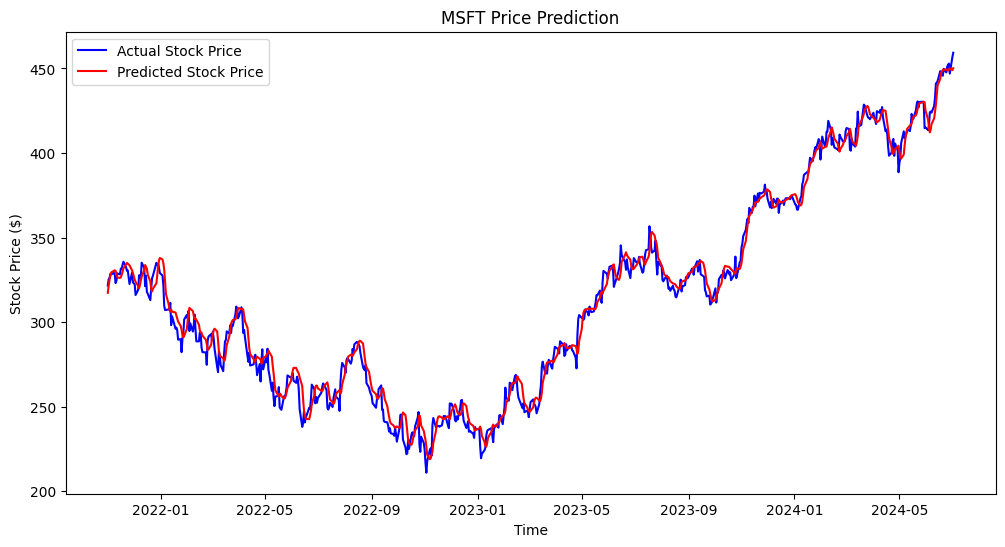

48.11646714406712

In [ ]:
msft = plot_predictions(predictions, 'MSFT')
accuracy

## Actual Drawdowns

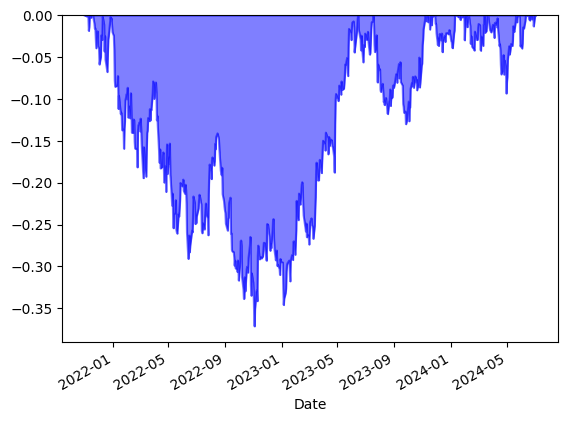

<Axes: xlabel='Date'>

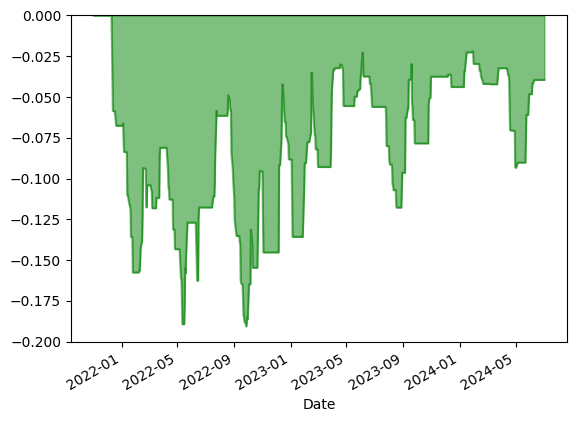

In [ ]:
actual = msft['Actual']
drawdowns(actual).plot(kind='area', color = 'blue' ,alpha=0.5)
plt.show()

actual.rolling(30).apply(max_drawdown).plot(kind='area', color = 'green' ,alpha=0.5)

## Predicted Drawdowns

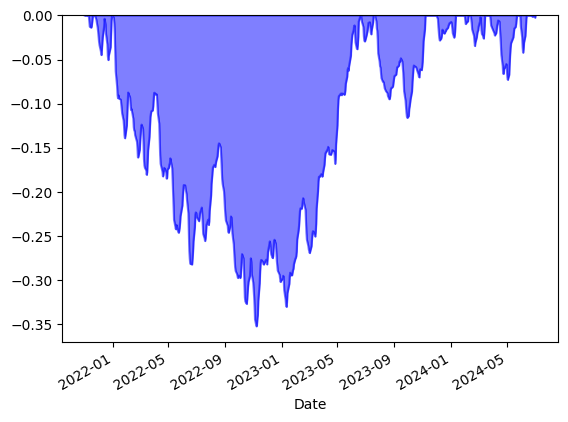

<Axes: xlabel='Date'>

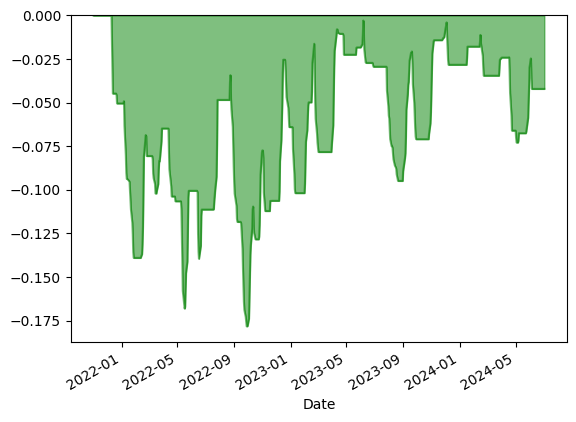

In [ ]:
# drawdowns
predicted = msft['Predicted']
drawdowns(predicted).plot(kind='area', color = 'blue' ,alpha=0.5)
plt.show()

# applied on a rolling basis of 30 days
predicted.rolling(30).apply(max_drawdown).plot(kind='area', color = 'green' ,alpha=0.5)

# Google

In [ ]:
predictions, accuracy = run_LSTM(df, 'GOOGL', lstm_units = 100, num_layers = 1, dropout = 0, epochs = 40, batch_size = 60, learning_rate=0.005)

Epoch 1/40
48/48 [==============================] - 16s 258ms/step - loss: 0.0039
Epoch 2/40
48/48 [==============================] - 10s 215ms/step - loss: 8.8797e-05
Epoch 3/40
48/48 [==============================] - 10s 204ms/step - loss: 6.8559e-05
Epoch 4/40
48/48 [==============================] - 9s 187ms/step - loss: 5.8338e-05
Epoch 5/40
48/48 [==============================] - 11s 221ms/step - loss: 6.2234e-05
Epoch 6/40
48/48 [==============================] - 11s 222ms/step - loss: 6.3285e-05
Epoch 7/40
48/48 [==============================] - 8s 177ms/step - loss: 7.3160e-05
Epoch 8/40
48/48 [==============================] - 11s 222ms/step - loss: 5.7167e-05
Epoch 9/40
48/48 [==============================] - 10s 219ms/step - loss: 5.2888e-05
Epoch 10/40
48/48 [==============================] - 9s 192ms/step - loss: 5.4003e-05
Epoch 11/40
48/48 [==============================] - 11s 233ms/step - loss: 5.3472e-05
Epoch 12/40
48/48 [==============================] - 10s 21

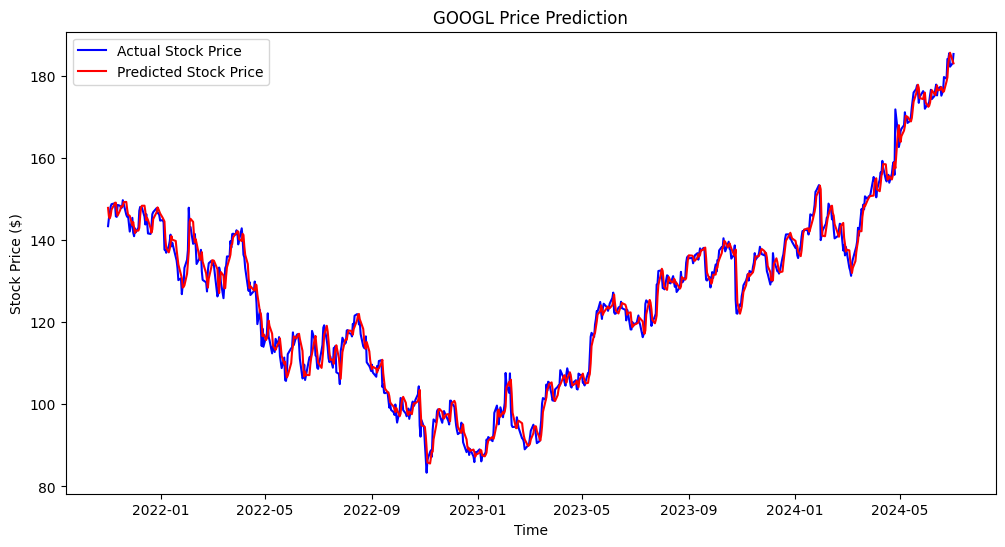

7.44169690766

In [ ]:
googl = plot_predictions(predictions, 'GOOGL')
accuracy

## Actual Drawdowns

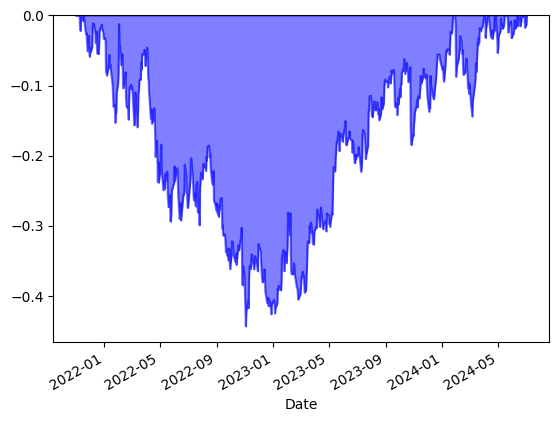

<Axes: xlabel='Date'>

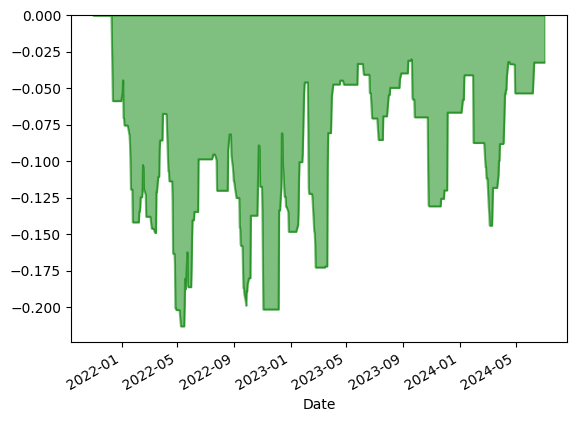

In [ ]:
actual = googl['Actual']
drawdowns(actual).plot(kind='area', color = 'blue' ,alpha=0.5)
plt.show()

actual.rolling(30).apply(max_drawdown).plot(kind='area', color = 'green' ,alpha=0.5)

## Predicted Drawdowns

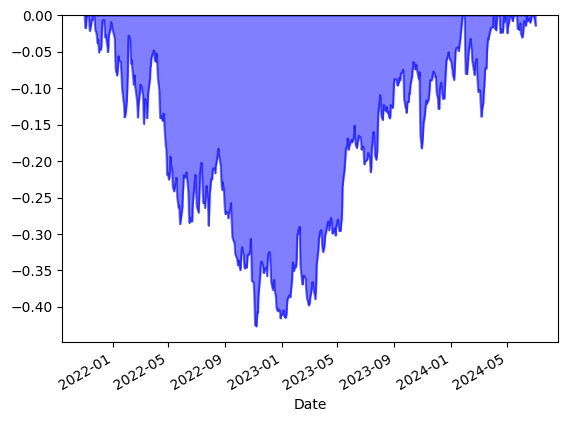

<Axes: xlabel='Date'>

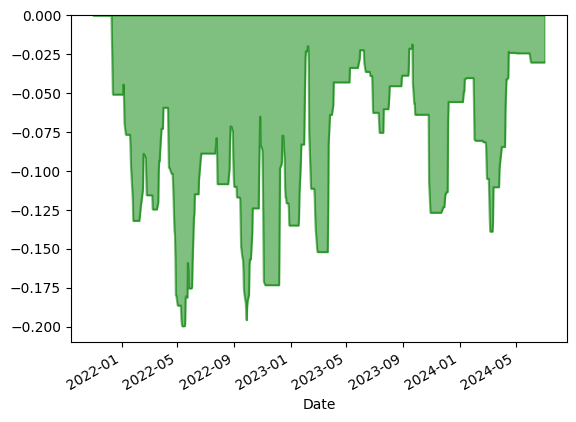

In [ ]:
# drawdowns
predicted = googl['Predicted']
drawdowns(predicted).plot(kind='area', color = 'blue' ,alpha=0.5)
plt.show()

# applied on a rolling basis of 30 days
predicted.rolling(30).apply(max_drawdown).plot(kind='area', color = 'green' ,alpha=0.5)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Function to create the model
def create_model(lstm_units=150, num_layers=1, dropout=0.0, learning_rate=0.001):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(LSTM(lstm_units, return_sequences=True, input_shape=(60, 1)))
        else:
            model.add(LSTM(lstm_units, return_sequences=True))
        model.add(Dropout(dropout))
    model.add(LSTM(lstm_units))
    model.add(Dense(1))

    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Function to prepare data
def prepare_data(df, stock, seq_len=60):
    series = df[stock]
    data = np.array(series).reshape(-1, 1)

    # Step 1 - Normalize
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    # Step 2 - Split into training and testing
    p = 0.8
    train_size = int(len(scaled_data) * p)
    train, test = scaled_data[:train_size], scaled_data[train_size:]

    # Step 3 - Create sequences
    def create_sequences(data, seq_len):
        X, y = [], []
        for i in range(len(data) - seq_len):
            X.append(data[i:i + seq_len])
            y.append(data[i + seq_len])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train, seq_len)
    X_test, y_test = create_sequences(test, seq_len)

    return X_train, y_train, X_test, y_test, scaler

# Function to run hyperparameter tuning
def hyperparameter_tuning(df, stock):
    # Prepare data
    X_train, y_train, X_test, y_test, scaler = prepare_data(df, stock)

    # Wrap the model
    model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=1)

    # Define the parameter grid
    param_grid = {
        'lstm_units': [100, 150, 200],
        'num_layers': [1, 2, 3],
        'dropout': [0.0, 0.2, 0.4],
        'learning_rate': [0.001, 0.01],
        'epochs': [50, 100],
        'batch_size': [16, 32, 64]
    }

    # Set up GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

    # Fit the grid search
    grid_result = grid.fit(X_train, y_train)

    # Summarize the results
    print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, std, param in zip(means, stds, params):
        print(f"{mean} ({std}) with: {param}")

    # Evaluate the best model on the test set
    best_model = grid_result.best_estimator_.model
    predictions = best_model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test, predictions)
    print(f'Test MSE: {mse}')

    return best_model, grid_result.best_params_, mse


best_model, best_params, mse = hyperparameter_tuning(df, 'AAPL')

In [ ]:
!pip install keras-wrapper